In [1]:
from utils import config
from utils.seq2seq import data

from utils.seq2seq.batcher import *

from utils.seq2seq.train_util import *
from utils.seq2seq.rl_util import *
from utils.seq2seq.initialize import loadCheckpoint, save_model
from utils.seq2seq.write_result import *
from datetime import datetime as dt
from tqdm import tqdm
from translate.seq2seq_beam import *
from tensorboardX import SummaryWriter
import argparse
from utils.seq2seq.rl_util import *
from torch.distributions import Categorical

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 

parser = argparse.ArgumentParser()
parser.add_argument('--key_attention', type=bool, default=False, help = 'True/False')
parser.add_argument('--intra_encoder', type=bool, default=True, help = 'True/False')
parser.add_argument('--intra_decoder', type=bool, default=True, help = 'True/False')
parser.add_argument('--copy', type=bool, default=True, help = 'True/False') # for transformer

parser.add_argument('--model_type', type=str, default='seq2seq', choices=['seq2seq', 'transformer'])
parser.add_argument('--train_rl', type=bool, default=False, help = 'True/False')
parser.add_argument('--keywords', type=str, default='POS_keys', 
                    help = 'POS_keys / DEP_keys / Noun_adj_keys / TextRank_keys')

parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--rand_unif_init_mag', type=float, default=0.02)
parser.add_argument('--trunc_norm_init_std', type=float, default=0.001)
parser.add_argument('--mle_weight', type=float, default=1.0)
parser.add_argument('--gound_truth_prob', type=float, default=0.1)

parser.add_argument('--max_enc_steps', type=int, default=1000)
parser.add_argument('--max_dec_steps', type=int, default=50)
parser.add_argument('--min_dec_steps', type=int, default=8)
parser.add_argument('--max_epochs', type=int, default=10)
parser.add_argument('--vocab_size', type=int, default=50000)
parser.add_argument('--beam_size', type=int, default=16)
parser.add_argument('--batch_size', type=int, default=1)

parser.add_argument('--hidden_dim', type=int, default=512)
parser.add_argument('--emb_dim', type=int, default=300)
parser.add_argument('--gradient_accum', type=int, default=1)

parser.add_argument('--load_ckpt', type=str, default='0588000', help='0002000')
parser.add_argument('--word_emb_type', type=str, default='word2Vec', help='word2Vec/glove/FastText')
parser.add_argument('--pre_train_emb', type=bool, default=True, help = 'True/False') # 若pre_train_emb為false, 則emb type為NoPretrain


opt = parser.parse_args(args=[])
config = re_config(opt)
loggerName, writerPath = getName(config)   
logger = getLogger(loggerName)
print(loggerName)

# load_model_path = config.save_model_path + '/%s/%s.tar' % (loggerName, config.load_ckpt)

load_model_path = 'model/saved_models_old_main6Cat' + '/%s/%s.tar' % (loggerName, config.load_ckpt)
print(load_model_path)

I0515 00:19:54.894939 139962530326336 file_utils.py:35] PyTorch version 1.4.0 available.
2020-05-15 00:19:55 - Pointer_generator_word2Vec_Intra_Atten - INFO: - logger已啟動
I0515 00:19:55.823036 139962530326336 train_util.py:106] logger已啟動


Pointer_generator_word2Vec_Intra_Atten
model/saved_models_old_main6Cat/Pointer_generator_word2Vec_Intra_Atten/0588000.tar


In [2]:
vocab = Vocab(config.vocab_path, config.vocab_size)

# Prepare Seq2Seq Data

In [3]:
from utils.seq2seq.batcher import Example, Batch
import matplotlib.pyplot as plt

config.batch_size = 1
config.gound_truth_prob = 0.5
# config.gound_truth_prob = 1.0


# data = {'review':'klipsch promedia logitech z623 this review for all the folk who are decide between buy the logitech z623 and klipsch promedia for audio system with the best bang for the buck . was literally tear between the two system base inability compare both them side side any store . neither bestbuy frys greg nor any other major electronic store had these two the same time get decent comparison . also nearly impossible really understand how these would sound store environment where there lot ambient noise open space and lack acoustic room . decide purchase these two try these home and then return whichever find lack certain aspect . base evaluation decide keep the logitech z623 . evaluate the system use several music track which include classical pop rock trance and and play them simultaneously both the system same decibel level increment . apart from this also play certain movie scene which were bass heavy treble heavy and also scene have dialogue not gamer and did not evaluate the sound for this . mid and high the satellite the klipsch feature driver and tweeter . think this would provide crisper sound especially the high frequency . this might true certain instance . however where feel the klipsch fall short were the sound integration the two driver . depend your ear level there seem sweet spot where these provide more clarity overall sound over the z623 . however you move around either the driver seem overpower the other . for instance were kneel direct ear level line with the mid driver the mid range frequency seem more prominent . and were stand the tweeter seem overpower the mid . this huge downfall eye . the sound come from the tweeter and mid should well balance blend seamlessly . should feel like both the driver work together provide perfect acoustical blend . this was not the case with the klipsch . the z623 seem have much better balance sound come from the satellite give that they have only single full range driver . the sound also seem envelope the listener much better than the klipsch . although would have prefer slightly sharper sound from the z623 the high . bass the z623 sub produce bass . surprisingly upon do bass test the z623 had audible bass upto 20hz the klipsch sub pretty much go inaudible 35hz . the bass the z623 will actually rattle the hell out window and any other loosely secure item the room . however the bass from the z623 lack the thump feel where would have expect and this where the klipsch score over the z623 . the bass the klipsch more boomier than the z623 . however this only true until about the level the bass knob . beyond that the klipsch bass start distort and sound purely bad . lack the fidelity higher volume . about volume the klipsch driver actually start make internal thud noise which completely mess any audio . the z623 hold very well even full bass level . the bass sound more distributed and does not cause any the above issue . additionally the z623 also has lot more input port look more aesthetically pleasing and actually cheaper than the klipsch . also read lot review with the klipsch have quality issue and the speaker fail after few month year . independently both the system sound great . however head head comparison would definitely choose the logitech z623 .',
#         'summary':'audio system with the best bang for the buck',
#         config.keywords: " ".join(eval("['system', 'loosely', 'even', 'full']"))}

data = {'review':'this mongoose flat tire bike joke pretty easy assemble and gorgeous but catch tough the upper thigh area when you ride it . now been awhile since rode bike go take some get use too . never the less love this bike and make anyone look cool ride it .',
        'summary':'it is pretty easy to assemble and it is gorgeous but there is',
        config.keywords: "vet online supplement recommend",
       "percent_lcs": '40.0'}

ex = Example(config, vocab, data)
b = Batch([ex])

b.enc_pad_mask

enc_batch, enc_padding_mask, enc_lens, enc_batch_extend_vocab, extra_zeros, coverage, ct_e, enc_key_batch, enc_key_mask, enc_key_lens= \
                get_input_from_batch(b, config, batch_first = True)
dec_batch, dec_padding_mask, dec_lens, max_dec_len, target_batch = \
        get_output_from_batch(b, config, batch_first = True)

# plot_attention

In [4]:
def plot_enc_attention(data, X_label=None, Y_label=None):
    '''
    Plot the attention model heatmap
    Args:
      data: attn_matrix with shape [ty, tx], cutted before 'PAD'
      X_label: list of size tx, encoder tags
      Y_label: list of size ty, decoder tags
    '''
    fig, ax = plt.subplots(figsize=(20, 8)) # set figure size
    #   heatmap = ax.pcolor(data, cmap=plt.cm.Blues, alpha=0.9)
#     heatmap = ax.pcolor(data, cmap='viridis', alpha=0.9)
    heatmap = ax.pcolor(data, cmap='hot', alpha=0.9)
    plt.colorbar(heatmap)
  
  # Set axis labels
    if X_label != None and Y_label != None:
        X_label = [x_label for x_label in X_label]
        Y_label = [y_label for y_label in Y_label]

        xticks = range(0,len(X_label))
        ax.set_xticks(xticks, minor=False) # major ticks
        ax.set_xticklabels(X_label, minor = False, rotation=45)   # labels should be 'unicode'
        plt.xlabel('review words')
        
        yticks = range(0,len(Y_label))
        ax.set_yticks(yticks, minor=False)
        ax.set_yticklabels(Y_label, minor = False)   # labels should be 'unicode'
        plt.ylabel('Decode summary words')
        plt.title('Intra-Encoder Attention')

        ax.grid(True)
        
        
        
def plot_dec_attention(data, X_label=None, Y_label=None):
    '''
    Plot the attention model heatmap
    Args:
      data: attn_matrix with shape [ty, tx], cutted before 'PAD'
      X_label: list of size tx, encoder tags
      Y_label: list of size ty, decoder tags
    '''
    fig, ax = plt.subplots(figsize=(20, 8)) # set figure size
    #   heatmap = ax.pcolor(data, cmap=plt.cm.Blues, alpha=0.9)
#     heatmap = ax.pcolor(data, cmap='viridis', alpha=0.9)
    heatmap = ax.pcolor(data, cmap='hot', alpha=0.9)
    plt.colorbar(heatmap)
  
  # Set axis labels
    if X_label != None and Y_label != None:
        X_label = [x_label for x_label in X_label]
        Y_label = [y_label for y_label in Y_label]

        xticks = range(0,len(X_label))
        ax.set_xticks(xticks, minor=False) # major ticks
        ax.set_xticklabels(X_label, minor = False, rotation=45)   # labels should be 'unicode'
        plt.xlabel('past input words')
        
        yticks = range(0,len(Y_label))
        ax.set_yticks(yticks, minor=False)
        ax.set_yticklabels(Y_label, minor = False)   # labels should be 'unicode'
        plt.ylabel('Decode step words')
        plt.title('Intra-Decoder Attention')

        ax.grid(True)        

# Load Pointer-Generator Model

In [5]:
from seq2seq import Model
import torch.nn as nn
import torch as T
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
# from translate.seq2seq_beam import Beam

load_step = None
model = Model(pre_train_emb=config.pre_train_emb, 
              word_emb_type = config.word_emb_type, 
              vocab = vocab)

model = model.cuda()
optimizer = T.optim.Adam(model.parameters(), lr=config.lr)   


if os.path.exists(load_model_path):
    model, optimizer, load_step = loadCheckpoint(logger, load_model_path, model, optimizer)
    
decode = []
decode_2 = []
embed_words = []
with T.autograd.no_grad():
    enc_batch_ = model.embeds(enc_batch)  # Get embeddings for encoder input    
    enc_key_batch = model.embeds(enc_key_batch)  # Get key embeddings for encoder input
    enc_out, enc_hidden = model.encoder(enc_batch_, enc_lens)

    s_t = (enc_hidden[0], enc_hidden[1])  # Decoder hidden states
    x_t = get_cuda(T.LongTensor(len(enc_out)).fill_(START))  # Input to the decoder
    prev_s = None  # Used for intra-decoder attention (section 2.2 in https://arxiv.org/pdf/1705.04304.pdf)
    sum_temporal_srcs = None  # Used for intra-temporal attention (section 2.1 in https://arxiv.org/pdf/1705.04304.pdf)
    weight = None
    dec_weight = []
    
    
#     batch_size = len(enc_hidden[0])
#     beam_idx = T.LongTensor(list(range(config.batch_size)))

#     beams = [Beam(START, END, UNKNOWN_TOKEN, (enc_hidden[0][i], enc_hidden[1][i]), ct_e[i]) for i in range(batch_size)]   #For each example in batch, create Beam object
#     n_rem = batch_size                                                  #Index of beams that are active, i.e: didn't generate [STOP] yet
#     sum_temporal_srcs = None                                            #Number of examples in batch that didn't generate [STOP] yet
#     prev_s = None
    
    
    
    for t in range(min(max_dec_len, config.max_dec_steps)):
        use_gound_truth = get_cuda((T.rand(len(enc_out)) > config.gound_truth_prob)).long()  # Probabilities indicating whether to use ground truth labels instead of previous decoded tokens
        x_t = use_gound_truth * dec_batch[:, t] + (1 - use_gound_truth) * x_t  # Select decoder input based on use_ground_truth probabilities
        embed_words.append(x_t.item())
        x_t = model.embeds(x_t)  
        final_dist, s_t, ct_e, sum_temporal_srcs, prev_s, enc_attn, dec_attn = model.decoder(x_t, s_t, enc_out, enc_padding_mask,
                                                                                  ct_e, extra_zeros,
                                                                                  enc_batch_extend_vocab,
                                                                                  sum_temporal_srcs, prev_s, enc_key_batch, enc_key_mask)

       
        x_t = T.max(final_dist, dim=1)[1]  # Sample words from final distribution which can be used as input in next time step

        
        if t == 0: 
            weight = enc_attn; 
        else: 
            weight = T.cat((weight, enc_attn), 0)  
        
        dec_weight.append(dec_attn) 
        
        decode.append(x_t.item())
        # x軸是tgt words
        # y軸是src words
    # print(weight.shape)
print(decode)

dec_words = [vocab.id2word(d) for d in decode]
dec_words = " ".join(dec_words) 
data['dec_words'] = dec_words
print('dec_words',dec_words)

# embed_words = embed_words[1:]
# print(embed_words)
embed_words = [vocab.id2word(d) for d in embed_words]
embed_words = " ".join(embed_words) 
data['embed_words'] = embed_words
print('embed_words',embed_words)
print('summary',data['summary'])

I0515 00:19:58.844277 139962530326336 utils_any2vec.py:341] loading projection weights from ../Train-Data/Mix6_mainCat/Embedding/word2Vec/word2Vec.300d.txt
I0515 00:20:07.801090 139962530326336 utils_any2vec.py:405] loaded (49676, 300) matrix from ../Train-Data/Mix6_mainCat/Embedding/word2Vec/word2Vec.300d.txt


model/saved_models_old_main6Cat/Pointer_generator_word2Vec_Intra_Atten/0588000.tar


2020-05-15 00:20:09 - Pointer_generator_word2Vec_Intra_Atten - INFO: - Loaded model at model/saved_models_old_main6Cat/Pointer_generator_word2Vec_Intra_Atten/0588000.tar
I0515 00:20:09.116867 139962530326336 initialize.py:212] Loaded model at model/saved_models_old_main6Cat/Pointer_generator_word2Vec_Intra_Atten/0588000.tar
2020-05-15 00:20:09 - Pointer_generator_word2Vec_Intra_Atten - INFO: - Loaded model step = 588000, loss = 2.29, r_loss = 0.00 
I0515 00:20:09.118596 139962530326336 initialize.py:213] Loaded model step = 588000, loss = 2.29, r_loss = 0.00 


[884, 1202, 171, 100, 127, 1069, 6, 2704, 133, 2704, 14, 43, 133, 3]
dec_words catch tough pretty easy to assemble and gorgeous is gorgeous but it is [STOP]
embed_words [START] catch is pretty easy to assemble and it is gorgeous but there is
summary it is pretty easy to assemble and it is gorgeous but there is


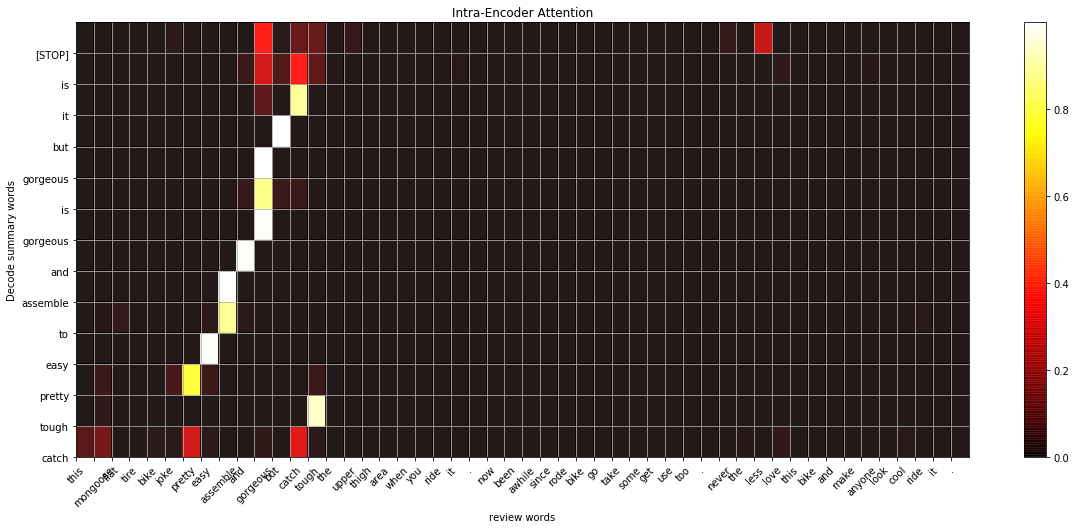

In [9]:
# plot_enc_attention(weight.cpu().data, X_label=data['review'].split(), Y_label=data['summary'].split())

plot_enc_attention(weight.cpu().data, X_label=data['review'].split(), Y_label=data['dec_words'].split())
# plot_attention(weight.cpu().data, X_label=data['review'].split(), Y_label=data['dec_words'].split())
# removeLogger(logger)

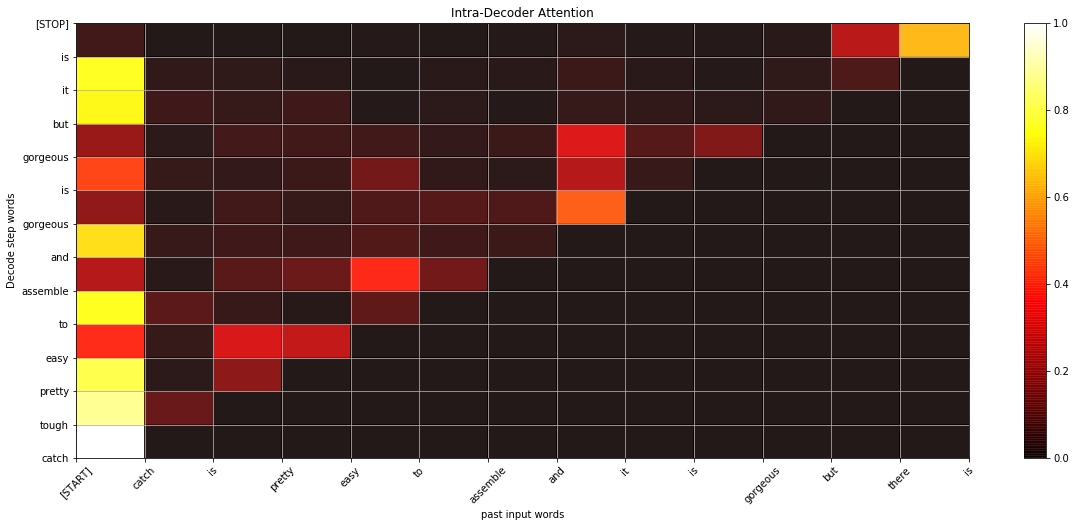

In [12]:
from torch import nn
import torch

new_dec_weight = None
for idx, w in enumerate(dec_weight[1:]):
    x = torch.tensor([[0.0]])
    w_ = x.repeat(1,len(decode)-(idx+2))
    new_w = torch.cat((w.cpu(), w_),dim=1)
    if idx == 0: new_dec_weight = new_w
    else: new_dec_weight = T.cat((new_dec_weight, new_w), 0) 



plot_dec_attention(new_dec_weight.data, X_label=data['embed_words'].split(), Y_label=data['dec_words'].split())

# 依照ground-true 0.5隨機使用summary token預測
# 每一個時間點的decode words 會調整自己過去關注的生成詞彙分布



In [11]:
dec_weight[1:][-1]

# len(decode)

tensor([[0.0517, 0.0035, 0.0026, 0.0029, 0.0054, 0.0017, 0.0049, 0.0186, 0.0043,
         0.0051, 0.0150, 0.2536, 0.6308]], device='cuda:0')